In [2]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSan

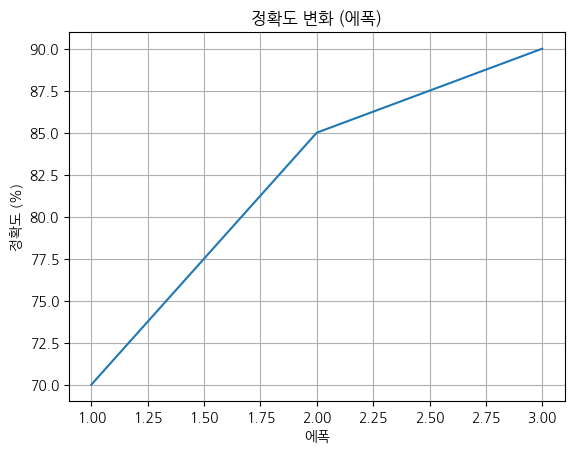

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 경로 (예시: NanumGothic)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 등록
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 테스트
plt.plot([1, 2, 3], [70, 85, 90])
plt.title("정확도 변화 (에폭)")
plt.xlabel("에폭")
plt.ylabel("정확도 (%)")
plt.grid(True)
plt.show()


In [4]:
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if 'Nanum' in font or 'Malgun' in font or 'Gothic' in font:
        print(font)


/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothic.ttf


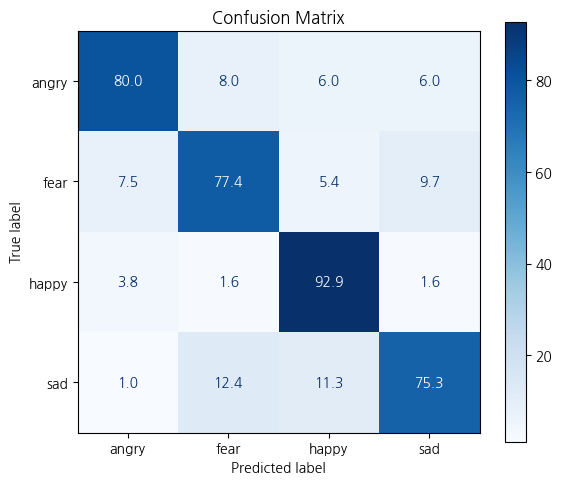

Classification Report:
               precision    recall  f1-score   support

       angry     0.8421    0.8000    0.8205       100
        fear     0.7579    0.7742    0.7660        93
       happy     0.8848    0.9286    0.9062       182
         sad     0.8022    0.7526    0.7766        97

    accuracy                         0.8347       472
   macro avg     0.8218    0.8138    0.8173       472
weighted avg     0.8338    0.8347    0.8338       472



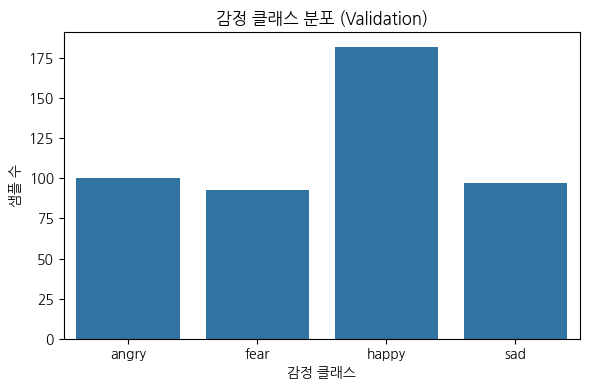

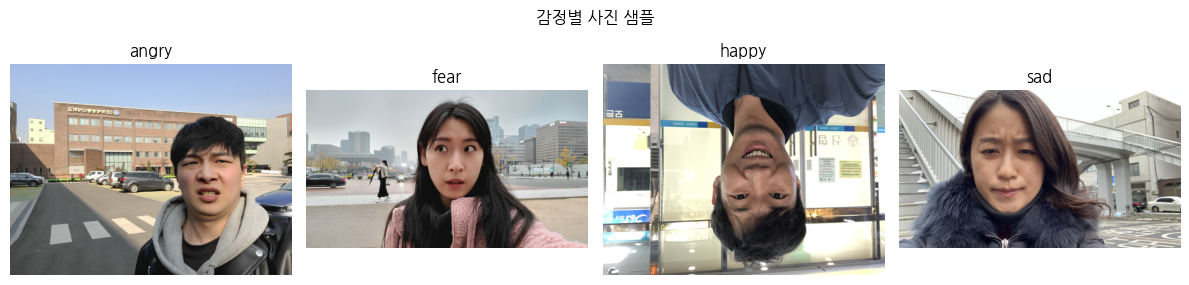

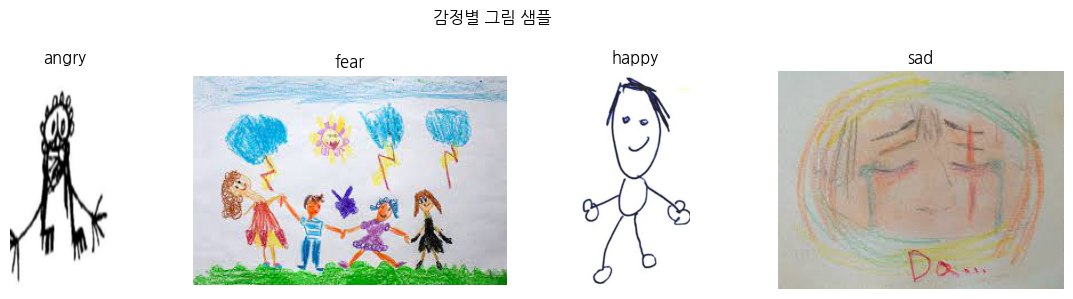

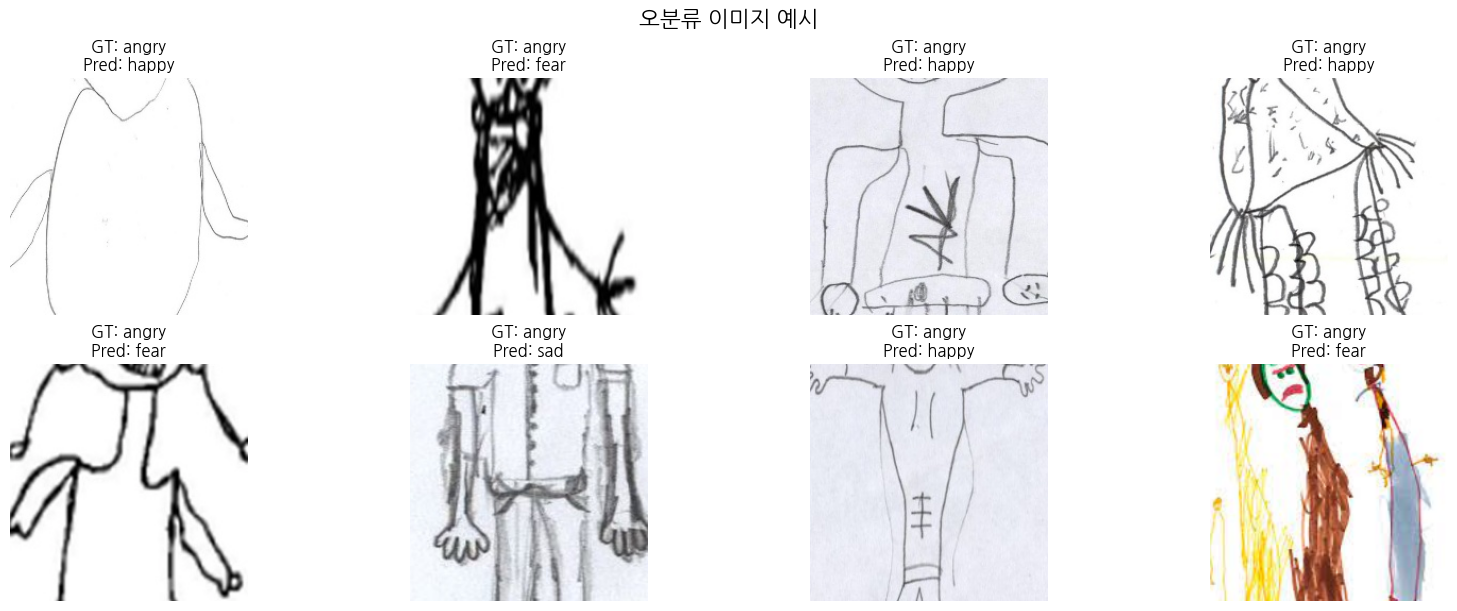

In [13]:
import os
import random
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image

# ==== 환경 설정 ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_CLASSES = 4
IMAGE_SIZE = 224
MODEL_PATH = "/workspace/models/DeiT/Deit_finetuned_drawing.pth"
PHOTO_DIR = "/workspace/datasets/dataset2yolo/photo/val"
DRAWING_DIR = "/workspace/datasets/dataset2yolo/drawing/val"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# ==== Transform 정의 ====
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ==== 데이터셋 로딩 ====
val_dataset = datasets.ImageFolder(DRAWING_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = val_dataset.classes

# ==== 클래스 분포 시각화 ====
def plot_class_distribution(dataset, title):
    counts = [0] * len(dataset.classes)
    for _, label in dataset.samples:
        counts[label] += 1

    plt.figure(figsize=(6, 4))
    sns.barplot(x=dataset.classes, y=counts)
    plt.title(title)
    plt.ylabel("샘플 수")
    plt.xlabel("감정 클래스")
    plt.tight_layout()
    plt.show()

# ==== 클래스별 샘플 이미지 시각화 ====
def plot_sample_images(root_dir, title):
    fig, axs = plt.subplots(1, len(class_names), figsize=(12, 3))
    for idx, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        img_file = random.choice(os.listdir(cls_dir))
        img = Image.open(os.path.join(cls_dir, img_file)).convert("RGB")
        axs[idx].imshow(img)
        axs[idx].set_title(cls)
        axs[idx].axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# ==== 모델 로딩 ====
model = timm.create_model("deit_base_patch16_224", pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ==== 예측 수행 ====
all_preds = []
all_labels = []
misclassified_imgs = []
misclassified_preds = []
misclassified_trues = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(preds)):
            if preds[i] != labels[i] and len(misclassified_imgs) < 8:
                misclassified_imgs.append(imgs[i].cpu())
                misclassified_preds.append(preds[i].item())
                misclassified_trues.append(labels[i].item())

# ==== 혼동 행렬 ====
cm = confusion_matrix(all_labels, all_preds, normalize="true") * 100  # 정규화 + 백분율
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, values_format=".1f")  # 소수점 1자리까지
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==== Classification Report 출력 ====
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n", report)

# ==== 오분류 이미지 시각화 ====
def show_misclassified_images(imgs, preds, trues):
    fig, axs = plt.subplots(2, 4, figsize=(16, 6), constrained_layout=True)
    axs = axs.flatten()
    for i in range(len(imgs)):
        img = imgs[i].permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
        img = torch.clamp(img, 0, 1).numpy()
        axs[i].imshow(img)
        axs[i].set_title(f"GT: {class_names[trues[i]]}\nPred: {class_names[preds[i]]}")
        axs[i].axis('off')

    fig.suptitle("오분류 이미지 예시", fontsize=16)
    plt.show()

# ==== 시각화 실행 ====
plot_class_distribution(val_dataset, "감정 클래스 분포 (Validation)")
plot_sample_images(PHOTO_DIR, "감정별 사진 샘플")
plot_sample_images(DRAWING_DIR, "감정별 그림 샘플")
show_misclassified_images(misclassified_imgs, misclassified_preds, misclassified_trues)


In [14]:
import torch.nn.functional as F
import numpy as np

# === 클래스별 성능 평가 및 출력 ===
def evaluate_classwise(all_preds, all_labels, model_outputs, class_names):
    print("\n< 성능 평가 >")

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probs = F.softmax(model_outputs, dim=1).cpu().numpy()

    total = len(all_labels)
    correct = (all_preds == all_labels).sum()
    acc = correct / total * 100
    print(f"전체 정확도: {correct}/{total} = {acc:.2f}%")

    print("\n<클래스 별 상세 성능>")
    for i, class_name in enumerate(class_names):
        class_mask = (all_labels == i)
        cls_total = class_mask.sum()
        cls_preds = all_preds[class_mask]
        cls_probs = probs[class_mask, i]  # 정답 클래스에 대한 신뢰도
        correct_preds = (cls_preds == i).sum()
        incorrect_preds = cls_total - correct_preds
        accuracy = correct_preds / cls_total * 100 if cls_total > 0 else 0
        mean_conf = cls_probs.mean() if cls_total > 0 else 0

        print(f"- {class_name}")
        print(f"    - 총 이미지 수: {cls_total}장")
        print(f"    - 정답 예측: {correct_preds}장")
        print(f"    - 오답 예측: {incorrect_preds}장")
        print(f"    - 정확도: {accuracy:.2f}%")
        print(f"    - 평균 신뢰도: {mean_conf:.3f}")

# === 예측 확률 저장 (다시 예측할 필요 없음) ===
model_outputs = []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        model_outputs.append(outputs)

# tensor → 하나로 합치기
model_outputs = torch.cat(model_outputs, dim=0)

# === 클래스별 성능 출력 ===
evaluate_classwise(all_preds, all_labels, model_outputs, class_names)


< 성능 평가 >
전체 정확도: 394/472 = 83.47%

<클래스 별 상세 성능>
- angry
    - 총 이미지 수: 100장
    - 정답 예측: 80장
    - 오답 예측: 20장
    - 정확도: 80.00%
    - 평균 신뢰도: 0.774
- fear
    - 총 이미지 수: 93장
    - 정답 예측: 72장
    - 오답 예측: 21장
    - 정확도: 77.42%
    - 평균 신뢰도: 0.710
- happy
    - 총 이미지 수: 182장
    - 정답 예측: 169장
    - 오답 예측: 13장
    - 정확도: 92.86%
    - 평균 신뢰도: 0.802
- sad
    - 총 이미지 수: 97장
    - 정답 예측: 73장
    - 오답 예측: 24장
    - 정확도: 75.26%
    - 평균 신뢰도: 0.739


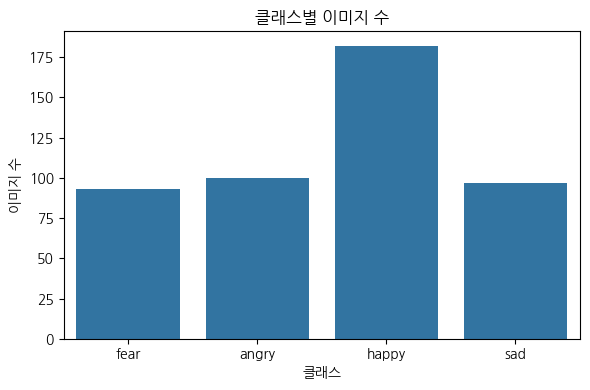

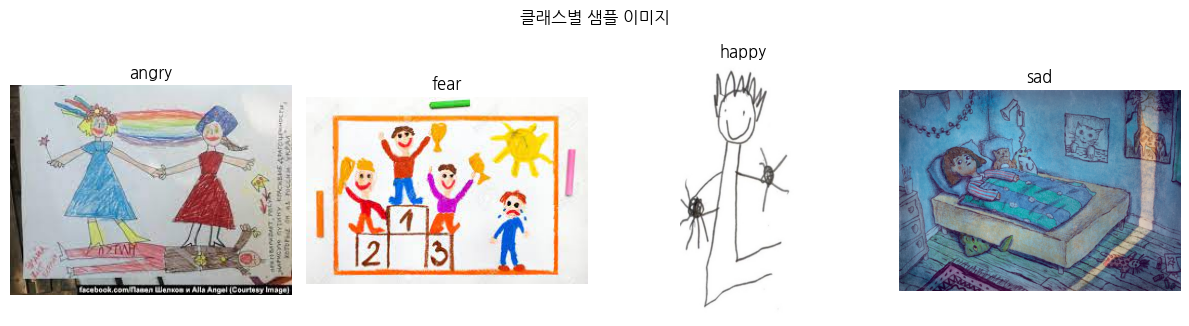

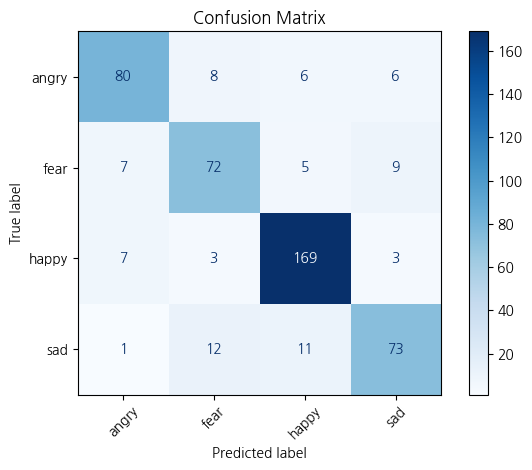

📋 Classification Report
              precision    recall  f1-score   support

       angry     0.8421    0.8000    0.8205       100
        fear     0.7579    0.7742    0.7660        93
       happy     0.8848    0.9286    0.9062       182
         sad     0.8022    0.7526    0.7766        97

    accuracy                         0.8347       472
   macro avg     0.8218    0.8138    0.8173       472
weighted avg     0.8338    0.8347    0.8338       472



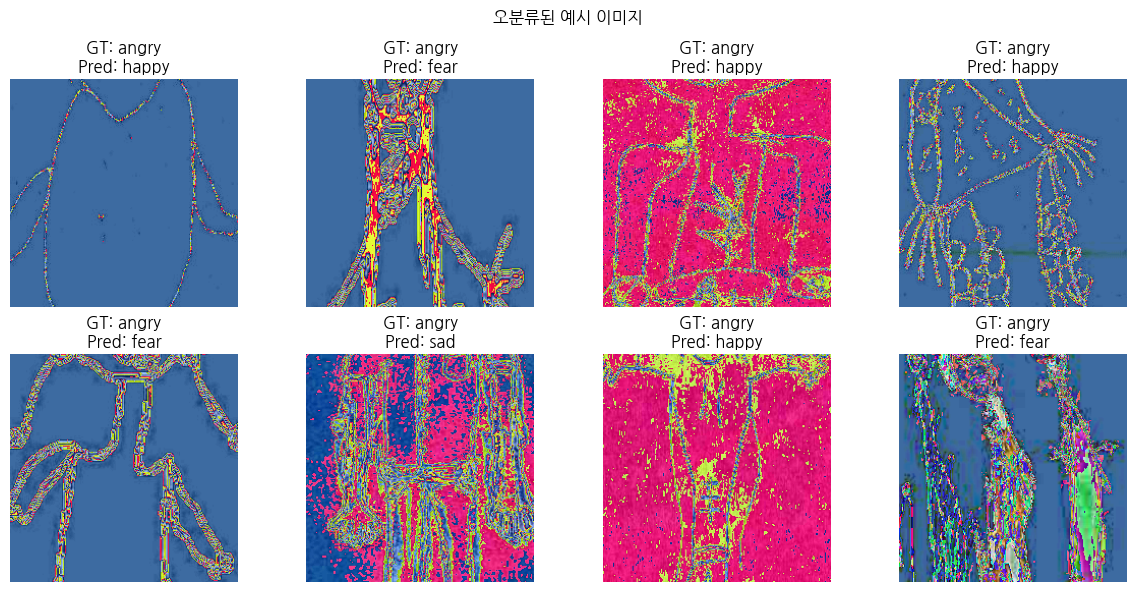

In [29]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import timm
from PIL import Image
import numpy as np
import random

# ✅ 설정
DATA_DIR = "/workspace/datasets/dataset2yolo/drawing/val"
MODEL_PATH = "/workspace/models/DeiT/Deit_finetuned_drawing.pth"
MODEL_NAME = "deit_base_patch16_224"
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
to_pil = transforms.ToPILImage()

# ✅ 클래스 분포 시각화
class_counts = {}
for cls in os.listdir(DATA_DIR):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("클래스별 이미지 수")
plt.xlabel("클래스")
plt.ylabel("이미지 수")
plt.tight_layout()
plt.show()

# ✅ 클래스별 샘플 이미지 표시
plt.figure(figsize=(12, 6))
classes = sorted(os.listdir(DATA_DIR))
for i, cls in enumerate(classes):
    cls_dir = os.path.join(DATA_DIR, cls)
    img_path = os.path.join(cls_dir, random.choice(os.listdir(cls_dir)))
    img = Image.open(img_path).convert("RGB")
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("클래스별 샘플 이미지")
plt.tight_layout()
plt.show()

# ✅ 데이터셋 로딩
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
idx2label = {v: k for k, v in dataset.class_to_idx.items()}

# ✅ 모델 로드
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ✅ 전체 예측
y_true, y_pred = [], []
misclassified = []

with torch.no_grad():
    for img, label in dataloader:
        img = img.to(DEVICE)
        output = model(img)
        pred = output.argmax(1).item()
        y_true.append(label.item())
        y_pred.append(pred)

        if pred != label.item() and len(misclassified) < 8:
            misclassified.append((img.cpu(), label.item(), pred))

# ✅ 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2label[i] for i in range(NUM_CLASSES)])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ✅ 성능 리포트
print("📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(NUM_CLASSES)], digits=4))

# ✅ 오분류 예시 이미지 표시
plt.figure(figsize=(12, 6))
for i, (img, label, pred) in enumerate(misclassified):
    plt.subplot(2, 4, i+1)
    img = to_pil(img.squeeze(0))
    plt.imshow(img)
    plt.title(f"GT: {idx2label[label]}\nPred: {idx2label[pred]}")
    plt.axis("off")
plt.suptitle("오분류된 예시 이미지")
plt.tight_layout()
plt.show()


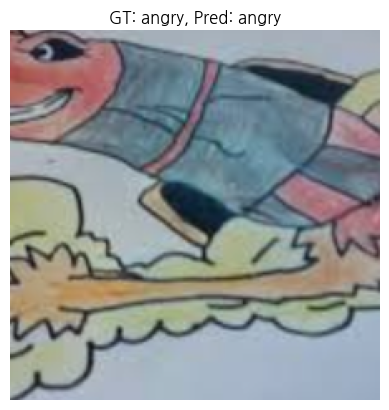

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.08956].


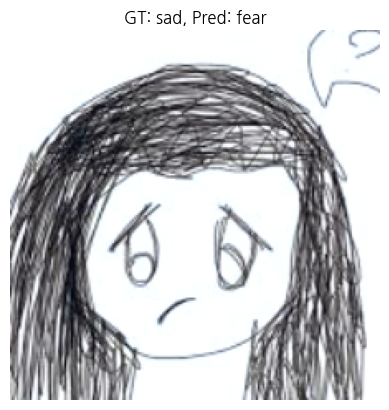

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35686275..1.08956].


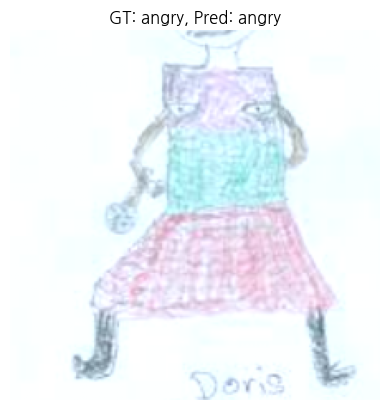

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.30588236..1.08956].


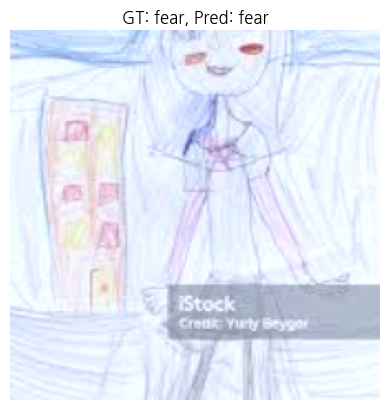

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035294116..1.08956].


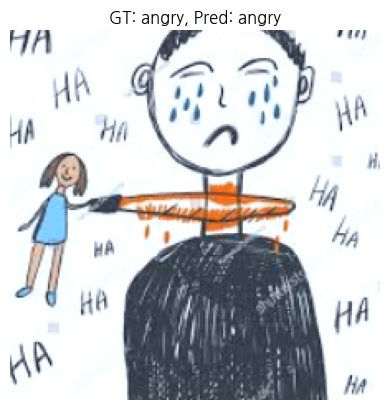

In [30]:
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4
VAL_DIR = "/workspace/datasets/dataset2yolo/drawing/val"

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def visualize_timm_model(model_path, model_name):
    model = timm.create_model(model_name, pretrained=False, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
    class_names = dataset.classes
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    for i, (img, label) in enumerate(loader):
        img = img.to(DEVICE)
        with torch.no_grad():
            output = model(img)
            pred = output.argmax(dim=1).item()
        # 시각화
        plt.imshow(img.cpu().squeeze().permute(1, 2, 0) * 0.229 + 0.485)
        plt.title(f"GT: {class_names[label.item()]}, Pred: {class_names[pred]}")
        plt.axis("off")
        plt.show()
        if i == 4:
            break

# 🔵 실행 예시
visualize_timm_model("/workspace/models/DeiT/Deit_finetuned_drawing.pth", "deit_base_patch16_224")


In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import timm

# === 환경 설정 ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_CLASSES = 4
IMAGE_SIZE = 224
MODEL_PATH = "/workspace/models/DeiT/Deittiny_finetuned_drawing.pth"
DRAWING_DIR = "/workspace/datasets/dataset2yolo/drawing/val"
CLASS_NAMES = ["Angry", "Fear", "Happy", "Sad"]  # 클래스 순서 맞게 설정

# === 1. 데이터 로더 ===
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(DRAWING_DIR, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = dataset.classes  # 혹은 CLASS_NAMES

# === 2. 평가 함수 ===
def evaluate_deit_model(model_path, val_loader, class_names):
    model = timm.create_model("deit_tiny_patch16_224", pretrained=False, num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)

            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# === 3. 클래스별 출력 함수 ===
def print_classwise_metrics(preds, labels, probs, class_names):
    total = len(labels)
    correct = (preds == labels).sum()
    acc = correct / total * 100

    print("\n< 성능 평가 >")
    print(f"전체 정확도: {correct}/{total} = {acc:.2f}%")

    print("\n<클래스 별 상세 성능>")
    for i, class_name in enumerate(class_names):
        mask = (labels == i)
        cls_total = mask.sum()
        cls_preds = preds[mask]
        cls_probs = probs[mask, i]

        correct_preds = (cls_preds == i).sum()
        incorrect_preds = cls_total - correct_preds
        accuracy = correct_preds / cls_total * 100 if cls_total > 0 else 0
        mean_conf = cls_probs.mean() if cls_total > 0 else 0

        print(f"- {class_name}")
        print(f"    - 총 이미지 수: {cls_total}장")
        print(f"    - 정답 예측: {correct_preds}장")
        print(f"    - 오답 예측: {incorrect_preds}장")
        print(f"    - 정확도: {accuracy:.2f}%")
        print(f"    - 평균 신뢰도: {mean_conf:.3f}")

# === 실행 ===
preds, labels, probs = evaluate_deit_model(MODEL_PATH, val_loader, CLASS_NAMES)
print_classwise_metrics(preds, labels, probs, CLASS_NAMES)



< 성능 평가 >
전체 정확도: 239/472 = 50.64%

<클래스 별 상세 성능>
- Angry
    - 총 이미지 수: 100장
    - 정답 예측: 92장
    - 오답 예측: 8장
    - 정확도: 92.00%
    - 평균 신뢰도: 0.735
- Fear
    - 총 이미지 수: 93장
    - 정답 예측: 21장
    - 오답 예측: 72장
    - 정확도: 22.58%
    - 평균 신뢰도: 0.259
- Happy
    - 총 이미지 수: 182장
    - 정답 예측: 80장
    - 오답 예측: 102장
    - 정확도: 43.96%
    - 평균 신뢰도: 0.379
- Sad
    - 총 이미지 수: 97장
    - 정답 예측: 46장
    - 오답 예측: 51장
    - 정확도: 47.42%
    - 평균 신뢰도: 0.446


## swin

/workspace/.conda/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Evaluating: 100%|██████████| 30/30 [00:10<00:00,  2.73it/s]

📋 Classification Report:
              precision    recall  f1-score   support

       angry     0.7807    0.8900    0.8318       100
        fear     0.8095    0.7312    0.7684        93
       happy     0.9235    0.9286    0.9260       182
         sad     0.8462    0.7938    0.8191        97

    accuracy                         0.8538       472
   macro avg     0.8400    0.8359    0.8363       472
weighted avg     0.8549    0.8538    0.8530       472



<Figure size 600x500 with 0 Axes>

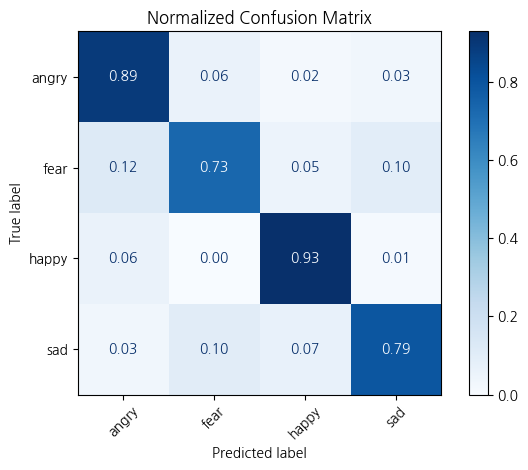

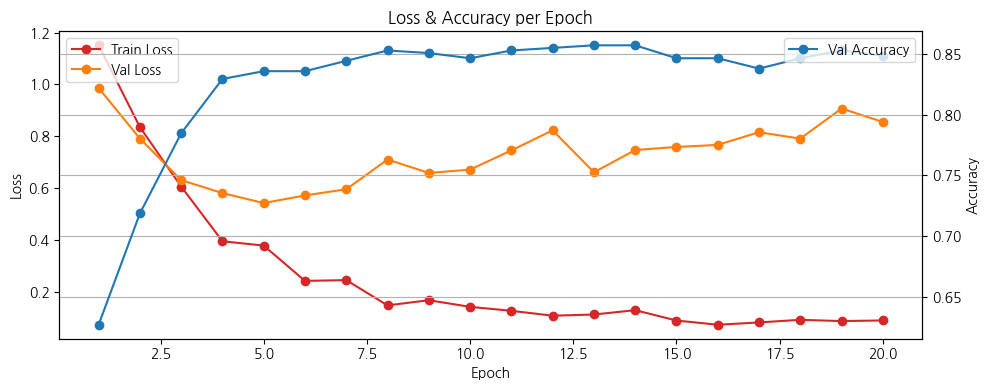

In [17]:
import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ==== 설정 ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "/workspace/models/drawing_finetuned_swin"
DRAWING_DIR = "/workspace/datasets/dataset2yolo/drawing/val"
BATCH_SIZE = 16

# ==== 모델 불러오기 ====
extractor = AutoFeatureExtractor.from_pretrained(MODEL_DIR)
model = AutoModelForImageClassification.from_pretrained(MODEL_DIR)
model.to(DEVICE)
model.eval()

# ==== 데이터 전처리 및 로더 ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=extractor.image_mean, std=extractor.image_std),
])

dataset = datasets.ImageFolder(DRAWING_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = dataset.classes

# ==== 예측 수행 ====
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs).logits
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ==== Classification Report ====
print("📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# ==== 정규화된 Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==== Loss / Accuracy 그래프 (20 Epoch 기준) ====
train_losses = [
    1.1508, 0.8357, 0.6067, 0.3958, 0.3792,
    0.2432, 0.2461, 0.1488, 0.1687, 0.1432,
    0.1279, 0.1090, 0.1137, 0.1303, 0.0905,
    0.0742, 0.0831, 0.0932, 0.0883, 0.0908
]
val_losses = [
    0.986343, 0.791737, 0.631262, 0.581561, 0.543001,
    0.572505, 0.596164, 0.710649, 0.659048, 0.671837,
    0.745954, 0.823375, 0.661527, 0.747308, 0.759225,
    0.767175, 0.815949, 0.791322, 0.907319, 0.855388
]
val_accuracies = [
    0.626866, 0.718550, 0.784648, 0.829424, 0.835821,
    0.835821, 0.844350, 0.852878, 0.850746, 0.846482,
    0.852878, 0.855011, 0.857143, 0.857143, 0.846482,
    0.846482, 0.837953, 0.846482, 0.852878, 0.848614
]

# 시각화
epochs = range(1, len(train_losses) + 1)
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(epochs, train_losses, label="Train Loss", color="tab:red", marker="o")
ax1.plot(epochs, val_losses, label="Val Loss", color="tab:orange", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2.plot(epochs, val_accuracies, label="Val Accuracy", color="tab:blue", marker="o")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")

plt.title("Loss & Accuracy per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


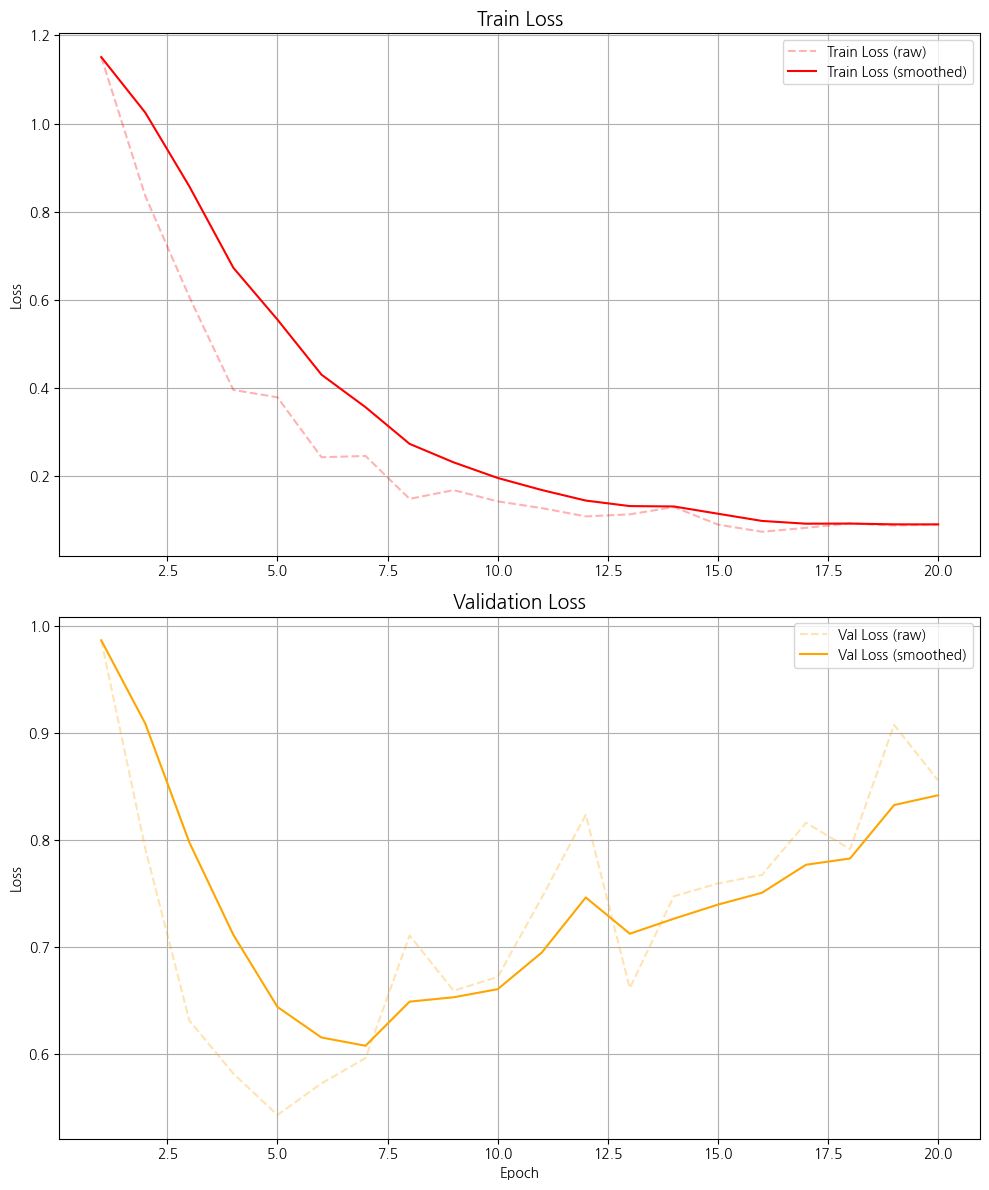

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# smoothing 함수
def smooth_curve(points, factor=0.6):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# 원본 로그
train_losses = [
    1.1508, 0.8357, 0.6067, 0.3958, 0.3792,
    0.2432, 0.2461, 0.1488, 0.1687, 0.1432,
    0.1279, 0.1090, 0.1137, 0.1303, 0.0905,
    0.0742, 0.0831, 0.0932, 0.0883, 0.0908
]
val_losses = [
    0.986343, 0.791737, 0.631262, 0.581561, 0.543001,
    0.572505, 0.596164, 0.710649, 0.659048, 0.671837,
    0.745954, 0.823375, 0.661527, 0.747308, 0.759225,
    0.767175, 0.815949, 0.791322, 0.907319, 0.855388
]

# smoothing 적용
train_smooth = smooth_curve(train_losses)
val_smooth = smooth_curve(val_losses)

# 시각화 (정사각형 느낌으로)
epochs = range(1, len(train_losses) + 1)
fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # ⬅️ 정사각형 비율 조정

# Train Loss
axs[0].plot(epochs, train_losses, label="Train Loss (raw)", color="red", alpha=0.3, linestyle="--")
axs[0].plot(epochs, train_smooth, label="Train Loss (smoothed)", color="red")
axs[0].set_ylabel("Loss")
axs[0].set_title("Train Loss", fontsize=14)
axs[0].legend()
axs[0].grid(True)

# Val Loss
axs[1].plot(epochs, val_losses, label="Val Loss (raw)", color="orange", alpha=0.3, linestyle="--")
axs[1].plot(epochs, val_smooth, label="Val Loss (smoothed)", color="orange")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Validation Loss", fontsize=14)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
